# TAREA I - SEP I/A
<div style="text-align: justify;">

## 0. Esquema De Arquitectura Del Proyecto
Se presenta un breve esquema realizado en la aplicación Drawio que resume a grandes rasgos la forma de operación en que se realiza el estudio y proyecto presentado en este informe. En el que dos estudiantes pueden intercambiar conocimiento a través de la plataforma GitHub.

<div style="text-align: center;">
  <img src="IMAGENES/Esquema_Proyecto.PNG" alt="Descripción de la imagen" width="500"/>
</div>

## 1. Estudio De Ingeniería

### I. Terminología
* **SEN:** Sistema Eléctrico Nacional.
* **ST:** Sistema De Transmisión.
* **CC:** Centro de Control de un Coordinado.

### II. Límites Admisibles de Operación
En base a lo mencionado por la "Norma Técnica de Seguridad y Calidad de Servicio" [1], se definen a continuación los límites admisibles de operación para el estudio.

**A) Estándares de Instalaciones del SEN Para Estado Normal, Estado De Alerta y Estado de Emergencia.**

**[Artículo 5-19]** El SI deberá operar en Estado Normal con todos los elementos e instalaciones del ST y compensación de potencia reactiva disponibles, y suficientes márgenes y reserva de potencia reactiva en las unidades generadoras, compensadores estáticos y sincrónicos, para lo cual el Coordinador y los CC, según corresponda, deberán controlar que la magnitud de la tensión en las barras del SI esté comprendida entre:
* 0.97 y 1.03 pu, para instalaciones del ST con tensión nominal igual o superior a 500 [kV].
* 0.95 y 1.05 pu, para instalaciones del ST con tensión nominal igual o superior a 200 [kV] e inferior a 500 [kV].
* 0.93 y 1.07 pu para instalaciones del ST con tensión nominal inferior a 200 [kV].

**[Artículo 5-23]** En Estado de Alerta el Coordinador y los CC deberán controlar que la magnitud de la tensión en
las barras del SI esté comprendida entre:
* 0.95 y 1.05 pu, para instalaciones del Sistema de Transmisión con tensión nominal igual o superior a 500 [kV], siempre que el límite superior no exceda la tensión máxima de servicio de los equipos.
* 0.93 y 1.07 pu, para instalaciones del Sistema de Transmisión con tensión nominal igual o superior a 200 [kV] e inferior a 500 [kV], siempre que el límite superior no exceda la tensión máxima de servicio de los equipos.
* 0.90 y 1.10 pu, para instalaciones del Sistema de Transmisión con tensión nominal inferior a 200 [kV], siempre que el límite superior no exceda la tensión máxima de servicio de los equipos.

**[Artículo 5-47]** En Estado de Emergencia el Coordinador y los CC deberán controlar que la magnitud de la tensión
en las barras del SI esté comprendida entre:
* 0.93 y 1.05 pu, para instalaciones del Sistema de Transmisión con tensión nominal igual o superior a 500 [kV], siempre que el límite superior no exceda la tensión máxima de servicio de los equipos.
* 0.90 y 1.10 por unidad, para instalaciones del Sistema de Transmisión con tensión nominal igual o superior a 200 [kV] e inferior a 500 [kV], siempre que el límite superior no exceda la tensión máxima de servicio de los equipos.
* 0.90 y 1.10 por unidad, para instalaciones del Sistema de Transmisión con tensión nominal inferior a 200 [kV], siempre que el límite superior no exceda la tensión máxima de servicio de los equipos.

### III. Tipos de Modelados De Líneas
En general, para la modelación de líneas de transmisión existen dos enfoques: en primer lugar se tiene el modelamiento a través de **parámetros concentrados**, en el que la línea se modela como una serie de componentes concentrados distribuidos a lo largo de su longitud, basándose en la simplificación de la línea como un circuito equivalente, donde cada componente representa una característica eléctrica específica de la línea. Mientras que por otro lado, el segundo enfoque involucra el modelamiento de líneas a través de **parámetros distribuidos**, en el que la línea se modela como un circuito distribuido, y por lo tanto, donde los parámetros eléctricos varían continuamente a lo largo de la longitud de la línea. De manera que en lugar de utilizar componentes discretos (RLC), se utilizan funciones de distribución para representar la variación continua de estos parámetros.

Así entonces, mientras el modelado a través de **parámetros concentrados** es útil para análisis de circuitos de corriente alterna (AC) y para aplicaciones donde la longitud de la línea es relativamente corta en comparación con la longitud de onda de la señal, el modelado a través de **parámetros distribuidos** representa un enfoque mucho más preciso para modelar líneas de transmisión largas o para frecuencias más altas donde los efectos de distribución son significativos.

Respecto a la librería escogida para este estudio, se debe señalar que corresponde a la librería **PandaPower**. La cual trabaja directamente el modelado de líneas a través del uso de _parámetros concentrados_.
</div>

## 2. MODELO A

En base a la información suministrada para el **Sistema A** y mostrada en la figura se plantea el esquema con Panda Power. Y se realiza el flujo de carga respectivo para la carga que cambia en el rango $\pm 50\%$ de la potencia indicada.

<div style="text-align: center;">
  <img src="IMAGENES/MODELO_A.PNG" alt="Descripción de la imagen" width="200"/>
</div>

**OBSERVACIÓN:** Puesto que la carga posee un rango de operación, se calcula previamente este rango de la siguiente manera:

  $$Rango\ Carga = [1200 \times 0.5\ \text{MVA},\ 1200 \times 1.5\ \text{MVA}] = [600\ \text{MVA},\ 1800\ \text{MVA}]$$

In [10]:
import pandapower as pp
import math as mm

#Variables Globales
Tensiones = []
LineasP = []
Paso = 100 #MVA
#Parámetros de Línea
r1 = 0.02  #(Ohm/km)
x1 = 0.115 #(Ohm/km)
B1 = 19.1  #(nF/km)
Imax1 = 1  #(kA)
for i in range(600,1800+1,Paso): 
    net1 = pp.create_empty_network()
    #Barras
    b1_1 = pp.create_bus(net1, vn_kv=500, name="Barra 1")
    b2_1 = pp.create_bus(net1, vn_kv=500, name="Barra 2")
    #Calculo De Potencias En Carga
    FP1 = 0.9
    P1 = round(i * FP1, 2)
    Q1 = round(i * mm.sqrt(1 - FP1**2), 2)
    #Elementos De Barra
    pp.create_ext_grid(net1, bus=b1_1, vm_pu=1.00, name="Fuente Externa")
    pp.create_load(net1, bus=b2_1, p_mw=P1, q_mvar=Q1, name="Carga 1")
    pp.create_line_from_parameters(net1, name='Linea 1-2_1', length_km=500, from_bus=b1_1, to_bus=b2_1,
                                   r_ohm_per_km=r1, x_ohm_per_km=x1, c_nf_per_km=B1, max_i_ka=Imax1)
    pp.create_line_from_parameters(net1, name='Linea 1-2_2', length_km=500, from_bus=b1_1, to_bus=b2_1,
                                   r_ohm_per_km=r1, x_ohm_per_km=x1, c_nf_per_km=B1, max_i_ka=Imax1)
    #Flujo De Energía
    pp.runpp(net1)
    tension_barra2 = net1.res_bus.at[1,'vm_pu']
    perdidaL = net1.res_line.loc[0, 'pl_mw']
    Tensiones.append(tension_barra2)
    LineasP.append(perdidaL*2)

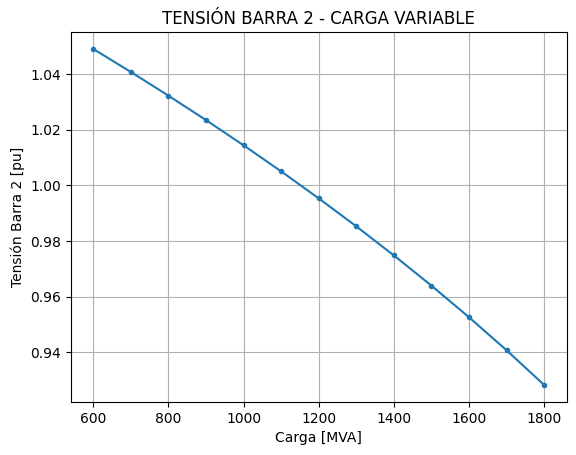

In [11]:
#A) COMPORTAMIENTO DE LA TENSIÓN PARA CARGA VARIABLE
import matplotlib.pyplot as plt
plt.plot(list(range(600,1800+1,100)), Tensiones, marker='.', linestyle='-')
plt.xlabel('Carga [MVA]')
plt.ylabel('Tensión Barra 2 [pu]')
plt.title('TENSIÓN BARRA 2 - CARGA VARIABLE')
plt.grid(True) 
plt.show()

<div style="text-align: justify;">

La gráfica obtenida de la variación de tensión en la **BARRA 2** para la carga variable conectada en el extremo receptor de la línea, muestra que a medida que el nivel de carga aumenta la tensión en el lado receptor disminuye. Esto es un resultado altamente esperable de manera teórica, puesto que con un simple análisis de la expresión para el cálculo de la potencia aparente, dada por:

$$S=V\times I^{*} \to V=\frac{S}{I^{*}}$$

Se puede determinar que al aumentar el nivel de demanda S, la corriente tambien debe aumentar y como esta es inversamente proporcional a la tensión, esta comienza a disminuir. Se ha de resaltar, que este es un hecho sumamente importante en SEP, puesto que permite dimensionar los efectos que podría provocar en los sistemas de transmisión una cantidad desproporcionada de demanda, que en un principio bajaría drásticamente las tensiones nominales de las barras de alimentación.
</div>

<div style="text-align: justify;">

Por otro lado, las tensiones de barra se encuentran muy por fuera de lo establecido por la normativa vigente (sobre todo en los extremos de la variación de carga), y por lo tanto, surge la idea del diseño de una compensación que permita normalizarlas a un valor aceptable. Para esto, se plantea una compensación simple (shunt) del tipo _capacitiva_ o _inductiva_ que logre elevar o reducir la tensión de la barra receptora respectivamente según corresponda a valores dentro de los límites estables mencionados por la normativa para el _ESTADO NORMAL_ de operación.

</div>

In [12]:
#B) Calculo de la compensación Shunt
import pandapower as pp
import math as mm

#Variables Globales
Tensiones_c = []
LineasP_c = []
Paso = 100 #MVA
Q_comp = []
#Parámetros de Línea
r1 = 0.02  #(Ohm/km)
x1 = 0.115 #(Ohm/km)
B1 = 19.1  #(nF/km)
Imax1 = 1  #(kA)
for i_c in range(600,1800+1,Paso):
    netc = pp.create_empty_network()
    #Barras
    b1_1 = pp.create_bus(netc, vn_kv=500, name="Barra 1")
    b2_1 = pp.create_bus(netc, vn_kv=500, name="Barra 2")
    #Calculo De Potencias En Carga
    FP1_c = 0.9
    P1_c = round(i_c * FP1_c, 2)
    Q1_c = round(i_c * mm.sqrt(1 - FP1_c**2), 2)
    #Elementos De Barra
    pp.create_ext_grid(netc, bus=b1_1, vm_pu=1.00, name="Fuente Externa")
    pp.create_load(netc, bus=b2_1, p_mw=P1_c, q_mvar=Q1_c, name="Carga 1")
    pp.create_line_from_parameters(netc, name='Linea 1-2_1', length_km=500, from_bus=b1_1, to_bus=b2_1,
                                   r_ohm_per_km=r1, x_ohm_per_km=x1, c_nf_per_km=B1, max_i_ka=Imax1)
    pp.create_line_from_parameters(netc, name='Linea 1-2_2', length_km=500, from_bus=b1_1, to_bus=b2_1,
                                   r_ohm_per_km=r1, x_ohm_per_km=x1, c_nf_per_km=B1, max_i_ka=Imax1)
    #Flujo De Energía
    pp.runpp(netc)
    tension_barra2_c = netc.res_bus.at[1,'vm_pu']
    #Calculo Iterativo De Compensación en Barras
    if tension_barra2_c>1.01: #Caso Sobretensión - Inductancia Shunt
        for k1 in range(100,1000,5):
            pp.create_shunt(netc, bus=b2_1, q_mvar=k1, p_mw=0, in_service=True)
            pp.runpp(netc)
            if netc.res_bus.at[1,'vm_pu']<= 1.01:
                Tensiones_c.append(netc.res_bus.at[1,'vm_pu'])
                LineasP_c.append(netc.res_line.loc[0, 'pl_mw']*2)
                Q_comp.append(k1)
                break
    elif tension_barra2_c<0.99: #Caso de Bajatensión - Capacitancia Shunt
        for k2 in range(100,1000,5):
            pp.create_shunt(netc, bus=b2_1, q_mvar=-1*k2, p_mw=0, in_service=True)
            pp.runpp(netc)
            if netc.res_bus.at[1,'vm_pu']>= 0.99:
                Tensiones_c.append(netc.res_bus.at[1,'vm_pu'])
                LineasP_c.append(netc.res_line.loc[0, 'pl_mw']*2)
                Q_comp.append(-1*k2)
                break
    elif 0.99<tension_barra2_c and tension_barra2_c<1.01:
        Tensiones_c.append(netc.res_bus.at[1,'vm_pu'])
        LineasP_c.append(netc.res_line.loc[0, 'pl_mw']*2)

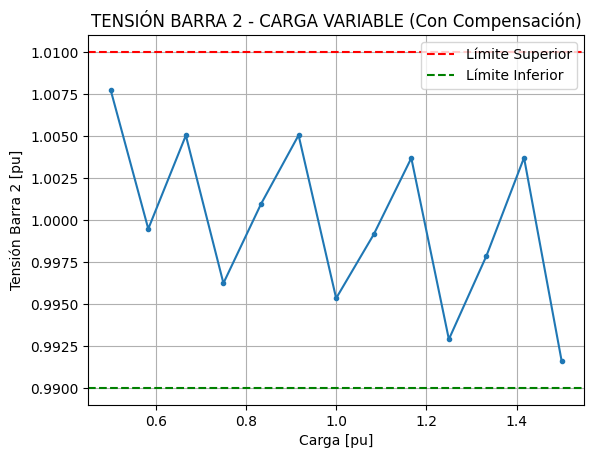

In [13]:
#Gráficas de Tensión con compensación
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.array(range(600, 1800 + 1, 100))/1200, Tensiones_c, marker='.', linestyle='-')
plt.axhline(y=1.01, color='r', linestyle='--',label='Límite Superior') 
plt.axhline(y=0.99, color='g', linestyle='--',label='Límite Inferior') 
plt.xlabel('Carga [pu]')
plt.ylabel('Tensión Barra 2 [pu]')
plt.title('TENSIÓN BARRA 2 - CARGA VARIABLE (Con Compensación)')
plt.grid(True) 
plt.legend() 
plt.show()

<div style="text-align: justify;">

Al colocar la compensación, se observa un efecto inmediato en la tensión de la **BARRA 2**, donde ésta se mantiene dentro de un rango aceptable según la normativa vigente. Esto sugiere que la compensación ha sido efectiva para estabilizar la tensión y mantenerla en niveles adecuados, a pesar de las fluctuaciones de carga. Este resultado subraya la importancia y la eficacia de implementar medidas correctivas adecuadas para garantizar la calidad y la confiabilidad del suministro eléctrico.


</div>

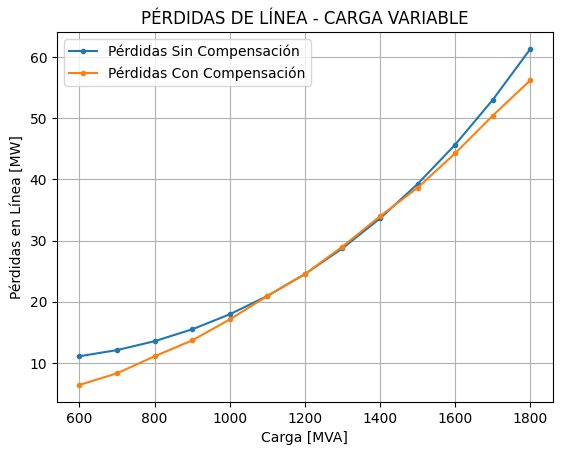

In [14]:
#C) PÉRDIDAS EN LA LÍNEA PARA EL RANGO DE POTENCIA DEMANDADA
import matplotlib.pyplot as plt
plt.plot(list(range(600,1800+1,100)), LineasP, marker='.', linestyle='-', label='Pérdidas Sin Compensación')
plt.plot(list(range(600,1800+1,100)), LineasP_c, marker='.', linestyle='-', label='Pérdidas Con Compensación')
plt.xlabel('Carga [MVA]')
plt.ylabel('Pérdidas en Línea [MW]')
plt.title('PÉRDIDAS DE LÍNEA - CARGA VARIABLE')
plt.grid(True)
plt.legend() 
plt.show()

<div style="text-align: justify;">
Existen notables diferencias en las pérdidas de potencia entre distintos rangos de carga antes y después de aplicar la compensación. Específicamente, se observa una reducción significativa en las pérdidas de potencia en los rangos de 600 a 900 MVA y de 1600 a 1800 MVA después de implementar la compensación. Esta mejora sugiere que la compensación ha sido efectiva para optimizar la eficiencia del sistema eléctrico al reducir las pérdidas de energía en esos intervalos de carga. Este efecto se explica porque al aumentar la tensión para mantener la misma potencia, se reduce la corriente, lo que a su vez disminuye las pérdidas según la fórmula:

$$P=I^{2}\times R$$

Por otro lado, en el rango de carga de 1100 a 1500 MVA, las pérdidas de potencia antes y después de la compensación son prácticamente idénticas. Esto sugiere que la compensación no ha tenido un impacto significativo en la reducción de las pérdidas de energía en este intervalo específico, posiblemente debido a que el sistema ya estaba operando de manera eficiente sin necesidad de ajustes adicionales.
</div>


## 3. MODELO B

En base a la información suministrada para el **Sistema B** y mostrada en la figura, se plantea el esquema con Panda Power y se realiza el flujo de carga respectivo en función de las cargas conectadas.

<div style="text-align: center;">
  <img src="IMAGENES/MODELO_B.PNG" alt="Descripción de la imagen" width="300"/>
</div>

In [1]:
import pandapower as pp

net2 = pp.create_empty_network()
#Carga Nominal Por Barra
P2 = 150 #MW
Q2 = 100 #MVAr
#Barras
b1 = pp.create_bus(net2, vn_kv=110, name='Barra 1', slack=True)
b2 = pp.create_bus(net2, vn_kv=220, name="Barra 2")
b1A = pp.create_bus(net2, vn_kv=220, name="Barra 1A")
b2A = pp.create_bus(net2, vn_kv=220, name="Barra 2A")
b3A = pp.create_bus(net2, vn_kv=220, name="Barra 3A")
b2B = pp.create_bus(net2, vn_kv=220, name="Barra 2B")
b1B = pp.create_bus(net2, vn_kv=220, name="Barra 1B")
#Elementos De Barra
pp.create_ext_grid(net2, bus=b1, vm_pu=1.00, name="Fuente Externa")
pp.create_load(net2, bus=b1A, p_mw=P2*0.2, q_mvar=Q2*0.2, name="Carga 1A")
pp.create_load(net2, bus=b2A, p_mw=P2*0.35, q_mvar=Q2*0.35, name="Carga 2A")
pp.create_load(net2, bus=b3A, p_mw=P2*0.15, q_mvar=Q2*0.15, name="Carga 3A")
pp.create_load(net2, bus=b2B, p_mw=P2*0.6, q_mvar=Q2*0.6, name="Carga 2B")
pp.create_load(net2, bus=b1B, p_mw=P2*0.1, q_mvar=Q2*0.1, name="Carga 1B")
#Elementos De Rama
tid = pp.create_transformer(net2, hv_bus=b2, lv_bus=b1, std_type="100 MVA 220/110 kV", name="Trafo 1")
#L 2 - 1A
pp.create_line(net2, from_bus=b2, to_bus=b1A, length_km=10, name="Linea 2-1A",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#L 1A - 2A
pp.create_line(net2, from_bus=b1A, to_bus=b2A, length_km=15, name="Linea 1A-2A",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#L 2A - 3A
pp.create_line(net2, from_bus=b2A, to_bus=b3A, length_km=20, name="Linea 2A-3A",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#L 3A - 2B
pp.create_line(net2, from_bus=b3A, to_bus=b2B, length_km=15, name="Linea 3A-2B",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#L 2B - 1B
pp.create_line(net2, from_bus=b2B, to_bus=b1B, length_km=30, name="Linea 2B-1B",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#L 1B - 2
pp.create_line(net2, from_bus=b1B, to_bus=b2, length_km=10, name="Linea 1B-2",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#Flujo De Carga
pp.runpp(net2)

<div style="text-align: justify;">
En primera instancia se analiza el estado de saturación de las líneas, para esto se realizan dos graficas de estudio. Una gráfica que muestra el nivel de saturación de corriente respecto al valor nominal tolerable por el tipo de linea usada y en segundo lugar, una gráfica del porcentaje de cargabilidad de ellas.

</div>

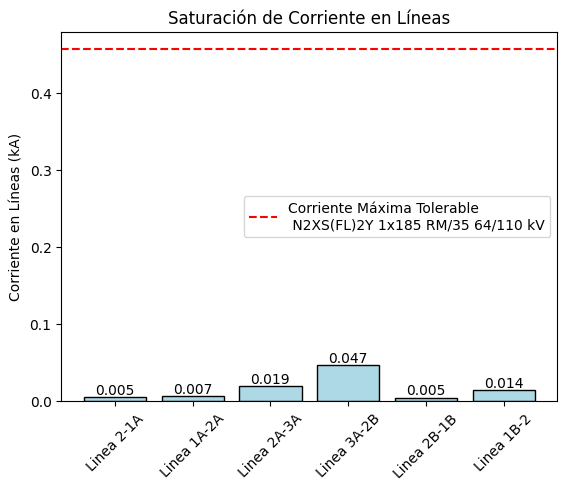

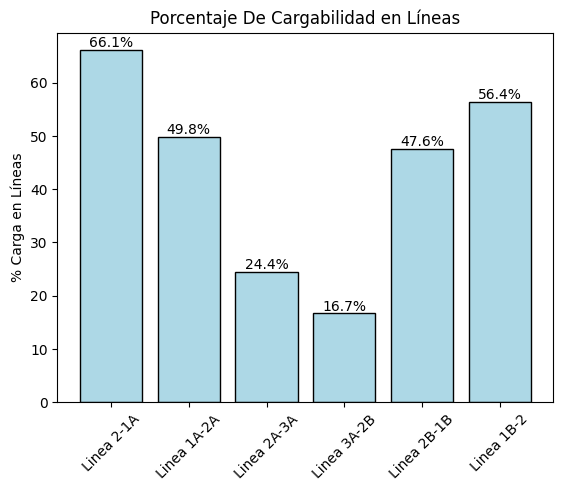

In [24]:
#A) ANÁLISIS DE SATURACIÓN EN LÍNEAS
resultados_lineas = net2.res_line
import matplotlib.pyplot as plt
Line_n = []
Satu_i = []
for n1, lin1 in net2.line.iterrows():
    Line_n.append(lin1['name'])
    res_line1 = resultados_lineas.loc[resultados_lineas.index == n1]
    Satu_i.append(abs(round(res_line1['i_from_ka'].values[0],5)-round(res_line1['i_to_ka'].values[0],5)))

plt.bar(Line_n, Satu_i,color='lightblue',edgecolor='black') 
plt.axhline(y=0.457, color='r', linestyle='--', label='Corriente Máxima Tolerable\n N2XS(FL)2Y 1x185 RM/35 64/110 kV') 
plt.ylabel('Corriente en Líneas (kA)')
plt.xticks(rotation=45) 
plt.title('Saturación de Corriente en Líneas')
for i1, valor1 in enumerate(Satu_i):
    valor1 = round(valor1,3)
    plt.annotate(str(valor1), xy=(i1, valor1), ha='center', va='bottom')
plt.legend() 
plt.show()

Line = []
Load_per = []
for n, lin in net2.line.iterrows():
    Line.append(lin['name'])
    res_line = resultados_lineas.loc[resultados_lineas.index == n]
    Load_per.append(round(res_line['loading_percent'].values[0],1))

plt.bar(Line, Load_per,color='lightblue',edgecolor='black') 
plt.ylabel('% Carga en Líneas')
plt.xticks(rotation=45) 
plt.title('Porcentaje De Cargabilidad en Líneas')
for i, valor in enumerate(Load_per):
    plt.annotate(f"{valor}%", xy=(i, valor), ha='center', va='bottom')
plt.show()

<div style="text-align: justify;">

En general, de los resultados obtenidos se puede observar como a medida que nos alejamos de la **barra 2** , se nota una disminución del flujo de potencia en las líneas, ya que la potencia es consumida progresivamente en cada barra, lo que reduce la cantidad de potencia que necesita ser transportada.

Por el lado de la _saturación_ se obtiene que las líneas funcionan muy por debajo del límite de corriente máxima que poseen las líneas en uso y por lo tanto no corren mayor riesgo durante la operación normal del sistena. De esta manera, no es necesario aplicar ningún tipo de medida extra que ayude a disminuir el nivel de saturación de estas. Además, la normativa mencionada, no es tan explícita respecto a los rangos óptimos de funcionamiento al menos en estado normal. Aún así, bajo simple criterio ingenieril, lo  recomedable sería que las líneas trabajen siempre muy por debajo del valor máximo de corriente nominal tolerable en las líneas, los que para el caso en estudio, se cumple a cabalidad.

</div>

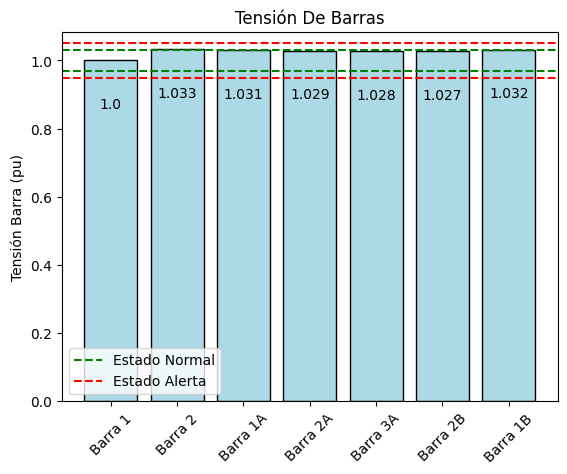

In [17]:
#B) Análisis de Tensiones de Barra
resultados_bus = net2.res_bus
import matplotlib.pyplot as plt
Bus = []
Voltage_pu = []
for n, lin in net2.bus.iterrows():
    Bus.append(lin['name'])
    res_bus1 = resultados_bus.loc[resultados_bus.index == n]
    Voltage_pu.append(round(res_bus1['vm_pu'].values[0],3))

plt.bar(Bus, Voltage_pu, color='lightblue',edgecolor='black') 
plt.axhline(y=0.97, color='g', linestyle='--',label='Estado Normal')
plt.axhline(y=1.03, color='g', linestyle='--')  
plt.axhline(y=0.95, color='r', linestyle='--',label='Estado Alerta')  
plt.axhline(y=1.05, color='r', linestyle='--') 
plt.ylabel('Tensión Barra (pu)')
plt.xticks(rotation=45) 
plt.title('Tensión De Barras')
for i, valor in enumerate(Voltage_pu):
    plt.annotate(str(valor), xy=(i, valor-0.15), ha='center', va='bottom')
plt.legend() 
plt.show()


<div style="text-align: justify;">
Se aprecia que desde la barras 2 hasta la 1B están cerca del límite superior del estado dentro de la norma, pero no alcanzan el estado de alerta. El hecho de que estas barras estén cerca del límite superior sugiere que la tensión en esas ubicaciones está operando en un rango crítico pero aún aceptable según las normativas establecidas. Esto indica que el sistema eléctrico está gestionando eficazmente la tensión para mantenerla dentro de los límites permitidos, aunque está cerca del límite superior.

Este estado puede ser manejado utilizando estrategias de compensación adecuadas, como ajustes en la regulación de tensión o el uso de dispositivos de control de voltaje, para asegurar que la tensión permanezca dentro de los márgenes seguros y no alcance el estado de alerta, que generalmente indica una condición más crítica que requiere intervención inmediata.

Claramente, de las medidas mencionadas para llevar el sistema a puntos de operación dentro de norma en ambos escenarios sigue resaltando la incorporación de compensación shunt, pues es una solución factible que permite obtener buenos resultados en las tensiones de barra deseadas. Así entonces, las sobretensiones mostrada en el gráfico adjunto podrían disminuir de manera considerable al incorporar esta medida, logrando que bajo ninguno de los dos escenarios en estudio se consigan tensiones de barra fuera de lo establecido por la norma.
</div>

### D. Métodos para Llevar a un Estado Normal el Sistema Eléctrico en Chile

<div style="text-align: justify;">

Para mantener un sistema eléctrico de potencia (SEP) en su estado normal y óptimo, es esencial enfocarse en tres áreas clave: mantenimiento preventivo y correctivo, equilibrio entre generación y demanda, y gestión de la calidad de energía. Por otro lado, despues de una falla o perturbación se debe asegurar la restauración eficiente y segura del servicio eléctrico para que este sea lo mas robusto y confiable.

#### Mantenimiento Preventivo y Correctivo

El mantenimiento preventivo y correctivo es fundamental para asegurar la fiabilidad y longevidad del sistema eléctrico.

1. **Inspecciones Regulares**: Se realizan inspecciones periódicas de todos los componentes del sistema, tales como líneas de transmisión, subestaciones, generadores y transformadores, para detectar y corregir problemas antes de que se conviertan en fallas graves.
2. **Programa de Mantenimiento Preventivo**: Se establece un calendario de mantenimiento que incluye la limpieza, ajuste y calibración de equipos, así como la sustitución de componentes que presenten desgaste.
3. **Mantenimiento Correctivo**: Se actúa de manera rápida y eficaz ante fallas inesperadas, reemplazando o reparando componentes dañados para minimizar el tiempo de inactividad y el impacto en el sistema.

#### Equilibrio entre Generación y Demanda

Mantener un equilibrio adecuado entre la generación y la demanda es crucial para la estabilidad del sistema eléctrico.

1. **Despacho de Carga**: Se ajusta la producción de energía en función de la demanda, utilizando sistemas de despacho de carga para coordinar la generación en tiempo real.
2. **Reservas Operativas**: Se mantienen reservas de generación para responder a variaciones inesperadas en la demanda o fallas en la generación. Esto incluye tanto reservas frías (generadores que pueden ser activados rápidamente) como reservas calientes (generadores en operación con capacidad adicional).
3. **Predicción de Demanda**: Se utilizan modelos de predicción y análisis de datos históricos para anticipar las necesidades de energía, permitiendo una planificación proactiva de la generación.
4. **Integración de Energías Renovables**: Se incluyen fuentes de energía renovable en la matriz de generación, ajustando la operación de generadores convencionales para compensar la variabilidad de recursos como el viento y el sol.

#### Gestión de la Calidad de Energía

La calidad de la energía es vital para el buen funcionamiento de los equipos conectados al sistema y para la eficiencia general del sistema eléctrico.

1. **Corrección del Factor de Potencia**: Se utilizan capacitores y reactores para corregir el factor de potencia, mejorando la eficiencia del sistema y reduciendo pérdidas de energía.
2. **Filtros de Armónicos**: Se instalan filtros de armónicos para mitigar las distorsiones en la forma de onda de la energía, que pueden afectar negativamente a los equipos y reducir la eficiencia del sistema.
3. **Monitoreo Continuo**: Se implementan sistemas de monitoreo continuo de la calidad de la energía, utilizando medidores inteligentes y sensores que proporcionen datos en tiempo real sobre voltaje, frecuencia y armónicos.
4. **Normas y Estándares**: Se asegura que el sistema cumpla con las normas y estándares internacionales de calidad de energía, realizando auditorías y ajustes necesarios para mantener la conformidad.

#### Métodos Específicos Utilizados en Chile

##### Monitoreo y Control Avanzado (SCADA)

El uso de sistemas de Supervisión, Control y Adquisición de Datos (SCADA) es fundamental para la operación y restauración del sistema eléctrico.

Los sistemas SCADA permiten monitorear en tiempo real todos los componentes del sistema eléctrico, desde las plantas generadoras hasta las subestaciones y líneas de transmisión. Empresas como el Coordinador Eléctrico Nacional utilizan SCADA para detectar rápidamente fallas y tomar decisiones informadas sobre cómo aislar y restaurar partes del sistema afectadas. El monitoreo continuo y la capacidad de control remoto facilitan la rápida identificación de problemas y la implementación de soluciones, minimizando el tiempo de inactividad.

##### Mantenimiento Preventivo y Predictivo

El mantenimiento preventivo y predictivo es crucial para asegurar la fiabilidad del sistema y prevenir fallas mayores.

Este método incluye inspecciones regulares, mantenimiento programado y el uso de tecnologías avanzadas para predecir posibles fallas antes de que ocurran. Empresas de transmisión eléctrica en Chile, como Transelec, implementan programas de mantenimiento que incluyen el uso de drones para inspección de líneas, termografía para detectar puntos calientes y análisis de vibraciones en equipos críticos. Al identificar y corregir problemas potenciales de manera anticipada, se reduce el riesgo de fallas inesperadas y se asegura la continuidad del servicio.

##### Gestión de la Demanda y Generación (Despacho Económico y Reservas Operativas)

Mantener un equilibrio adecuado entre la generación y la demanda es esencial para la estabilidad del sistema eléctrico.

El despacho económico optimiza la operación de las unidades generadoras en función de la demanda, mientras que las reservas operativas aseguran que haya capacidad adicional disponible para enfrentar variaciones inesperadas. El Coordinador Eléctrico Nacional realiza el despacho centralizado de generación, asegurando que las plantas más eficientes operen según las necesidades de la red y manteniendo reservas frías y calientes para emergencias. Este método permite una respuesta rápida y efectiva ante fluctuaciones en la demanda o fallas en la generación, garantizando la estabilidad y confiabilidad del suministro eléctrico.

##### Métodos para Restauración del Sistema

Para llevar el sistema de vuelta a un estado normal de operación después de una desconexión:

1. **Reconfiguración del Sistema (Switching)**: Redistribuir las cargas y reconfigurar el sistema mediante el cierre de interruptores adicionales para restablecer caminos alternativos para el flujo de potencia.
   
2. **Ajuste de Tap de Transformadores**: Ajustar el tap del transformador para cambiar la relación de transformación y regular la tensión en las barras.
   
3. **Uso de Compensación Reactiva**: Instalar o activar bancos de capacitores o reactores en puntos estratégicos del sistema para controlar la tensión.
   
4. **Control de Generación**: Redistribuir la generación de energía en el sistema, aumentando la generación en ciertas plantas y reduciendo en otras.
   
5. **Desconexión de Cargas No Críticas**: Desconectar temporalmente cargas que no son críticas para aliviar la carga en el sistema.


### E. Desconexión de línea 3A-2B

Se implementa un ajuste en el tap del transformador en nuestro código para optimizar las tensiones en las barras. Este proceso se basa en la premisa de que el transformador cuenta con taps ajustables, permitiendo así una regulación precisa de las tensiones operativas. 

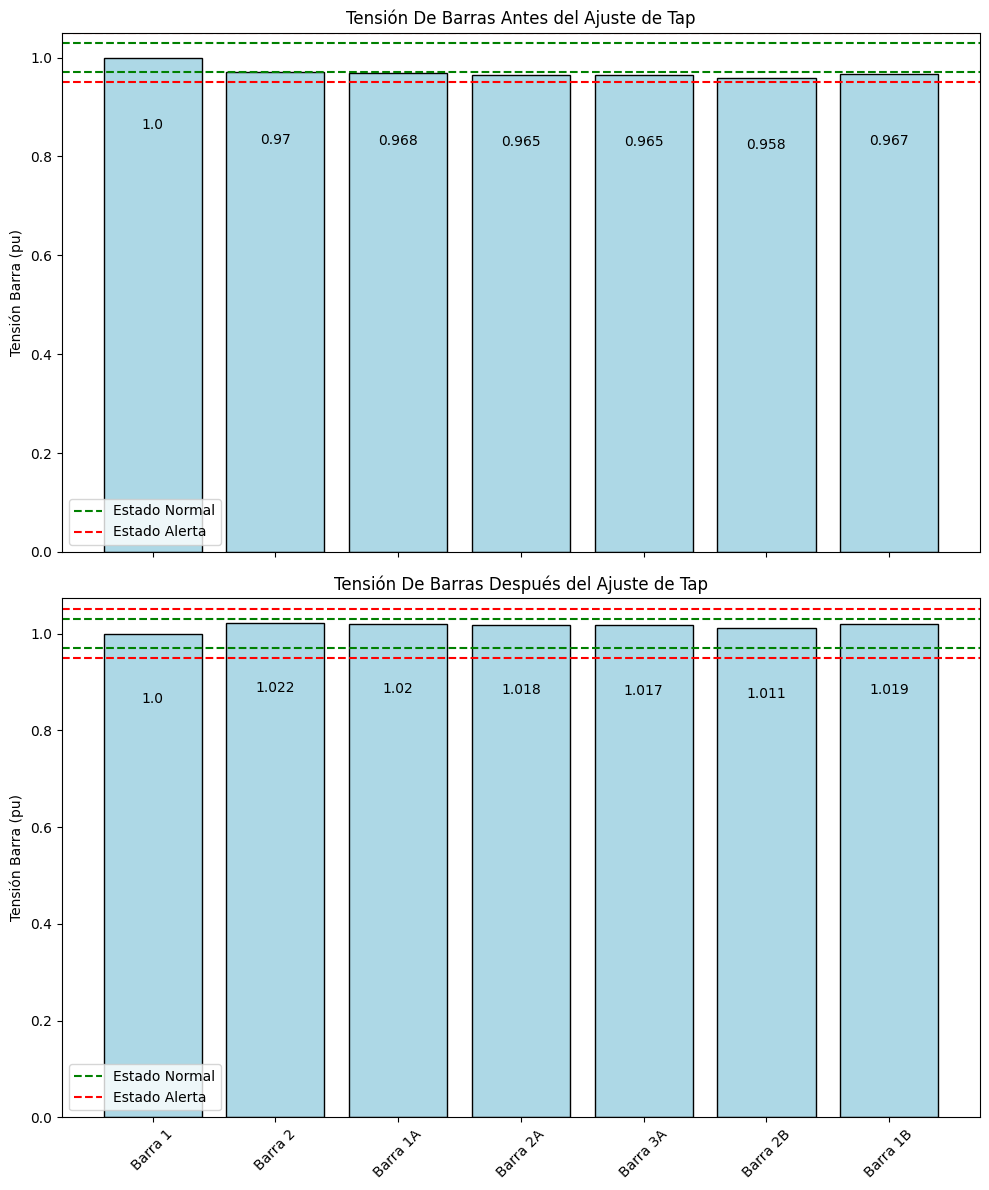

In [2]:
import pandapower as pp
import matplotlib.pyplot as plt

net4 = pp.create_empty_network()

# Carga Nominal Por Barra
P2 = 150  # MW
Q2 = 100  # MVAr

# Barras
b1 = pp.create_bus(net4, vn_kv=110, name='Barra 1', slack=True)
b2 = pp.create_bus(net4, vn_kv=220, name="Barra 2")
b1A = pp.create_bus(net4, vn_kv=220, name="Barra 1A")
b2A = pp.create_bus(net4, vn_kv=220, name="Barra 2A")
b3A = pp.create_bus(net4, vn_kv=220, name="Barra 3A")
b2B = pp.create_bus(net4, vn_kv=220, name="Barra 2B")
b1B = pp.create_bus(net4, vn_kv=220, name="Barra 1B")

# Elementos De Barra
pp.create_ext_grid(net4, bus=b1, vm_pu=1.00, name="Fuente Externa")
pp.create_load(net4, bus=b1A, p_mw=P2 * 0.2, q_mvar=Q2 * 0.2, name="Carga 1A")
pp.create_load(net4, bus=b2A, p_mw=P2 * 0.35, q_mvar=Q2 * 0.35, name="Carga 2A")
pp.create_load(net4, bus=b3A, p_mw=P2 * 0.15, q_mvar=Q2 * 0.15, name="Carga 3A")
pp.create_load(net4, bus=b2B, p_mw=P2 * 0.6, q_mvar=Q2 * 0.6, name="Carga 2B")
pp.create_load(net4, bus=b1B, p_mw=P2 * 0.1, q_mvar=Q2 * 0.1, name="Carga 1B")

# Elementos De Rama
pp.create_transformer(net4, hv_bus=b2, lv_bus=b1, std_type="100 MVA 220/110 kV", name="Trafo 1")
pp.create_line(net4, from_bus=b2, to_bus=b1A, length_km=10, name="Linea 2-1A",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net4, from_bus=b1A, to_bus=b2A, length_km=15, name="Linea 1A-2A",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net4, from_bus=b2A, to_bus=b3A, length_km=20, name="Linea 2A-3A",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net4, from_bus=b3A, to_bus=b2B, length_km=15, name="Linea 3A-2B",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=False)
pp.create_line(net4, from_bus=b2B, to_bus=b1B, length_km=30, name="Linea 2B-1B",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net4, from_bus=b1B, to_bus=b2, length_km=10, name="Linea 1B-2",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Flujo De Carga sin el ajuste de taps
pp.runpp(net4)

# Análisis de Tensiones de Barra
resultados_bus_antes = net4.res_bus
Bus = []
Voltage_pu_antes = []
for n, lin in net4.bus.iterrows():
    Bus.append(lin['name'])
    res_bus1 = resultados_bus_antes.loc[resultados_bus_antes.index == n]
    Voltage_pu_antes.append(round(res_bus1['vm_pu'].values[0], 3))

# Ajuste de tap del transformador
tid = net4.trafo.index[0]
net4.trafo.tap_pos.at[tid] = 2  # Ajustar el tap para aumentar la tensión

# Flujo De Carga después del ajuste de tap
pp.runpp(net4)

# Análisis de Tensiones de Barra Con el cambio de Taps
resultados_bus_despues = net4.res_bus
Voltage_pu_despues = []
for n, lin in net4.bus.iterrows():
    res_bus2 = resultados_bus_despues.loc[resultados_bus_despues.index == n]
    Voltage_pu_despues.append(round(res_bus2['vm_pu'].values[0], 3))

# Creación del gráfico
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Gráfico antes del ajuste de tap
ax1.bar(Bus, Voltage_pu_antes, color='lightblue', edgecolor='black')
ax1.axhline(y=0.97, color='g', linestyle='--', label='Estado Normal')
ax1.axhline(y=1.03, color='g', linestyle='--')
ax1.axhline(y=0.95, color='r', linestyle='--', label='Estado Alerta')
ax1.axhline(y=1.05, color='r', linestyle='--')
ax1.set_ylabel('Tensión Barra (pu)')
ax1.set_title('Tensión De Barras Antes del Ajuste de Tap')
ax1.legend()
for i, valor in enumerate(Voltage_pu_antes):
    ax1.annotate(str(valor), xy=(i, valor - 0.15), ha='center', va='bottom')

# Gráfico después del ajuste de tap
ax2.bar(Bus, Voltage_pu_despues, color='lightblue', edgecolor='black')
ax2.axhline(y=0.97, color='g', linestyle='--', label='Estado Normal')
ax2.axhline(y=1.03, color='g', linestyle='--')
ax2.axhline(y=0.95, color='r', linestyle='--', label='Estado Alerta')
ax2.axhline(y=1.05, color='r', linestyle='--')
ax2.set_ylabel('Tensión Barra (pu)')
ax2.set_title('Tensión De Barras Después del Ajuste de Tap')
ax2.legend()
for i, valor in enumerate(Voltage_pu_despues):
    ax2.annotate(str(valor), xy=(i, valor - 0.15), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


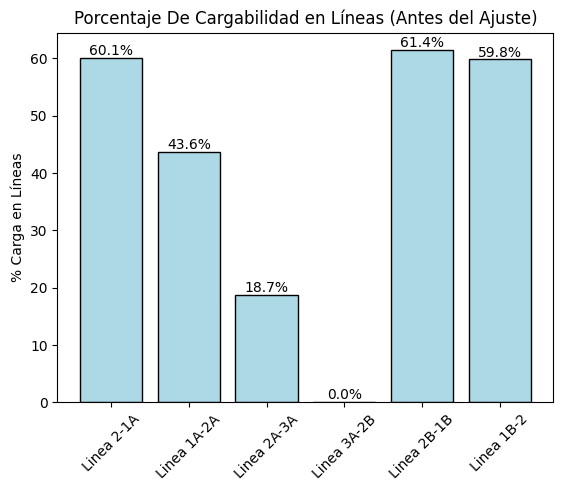

In [3]:
#Cargabilidad en las Líneas 
resultados_lineas = net4.res_line
import matplotlib.pyplot as plt
Line = []
Load_per = []
for n, lin in net4.line.iterrows():
    Line.append(lin['name'])
    res_line = resultados_lineas.loc[resultados_lineas.index == n]
    Load_per.append(round(res_line['loading_percent'].values[0],1))

plt.bar(Line, Load_per,color='lightblue',edgecolor='black') 
plt.ylabel('% Carga en Líneas')
plt.xticks(rotation=45) 
plt.title('Porcentaje De Cargabilidad en Líneas (Antes del Ajuste)')
for i, valor in enumerate(Load_per):
    plt.annotate(f"{valor}%", xy=(i, valor), ha='center', va='bottom')
plt.show()


#### Tensiones en Barras

**Antes del ajuste:**
Algunas barras presentan tensiones fuera de los límites normales debido a la desconexión de líneas, lo cual puede comprometer la estabilidad del sistema.

**Después del ajuste:**
Las tensiones estan controladas dentro de los límites aceptables (0.97 - 1.03 pu), indicando una mejora significativa en la estabilidad del sistema eléctrico.

### Cargabilidad de Líneas

**Antes del ajuste:**
Es posible que las líneas restantes estén más cargadas debido a la redistribución del flujo de potencia, lo que aumenta el riesgo de fallos en la red.

**Después del ajuste:**
 La carga en las líneas debe ser más equilibrada, reduciendo el riesgo de sobrecarga y fallos.

Estas medidas son esenciales para mantener la operación segura y eficiente del sistema eléctrico. Aseguran que las tensiones y las cargas se mantengan dentro de límites aceptables, mejorando la confiabilidad y estabilidad del suministro eléctrico global.


### F. Conexión de línea 3A-2B e inyeccion de un 20% más de reactivos desde el generador


<div style="text-align: justify;">
Para esta tarea, no es posible inyectar reactivos en la barra slack debido a que, por definición, esta barra compensará al sistema. Para observar efectos en la línea por el aumento de reactivos, se incrementan estos en un 20% en todas las cargas, forzando a la generación a inyectar un 20% más de reactivos respecto al total de las cargas.

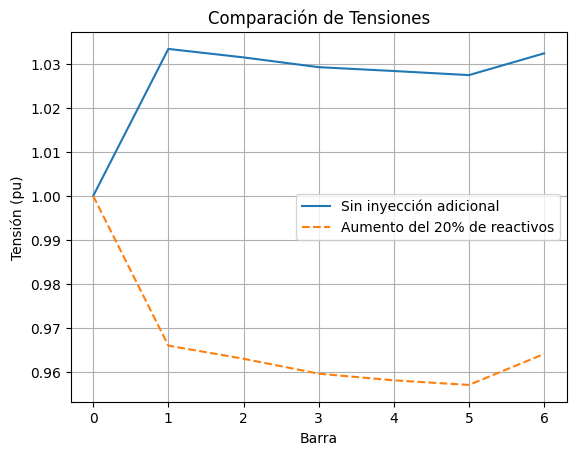

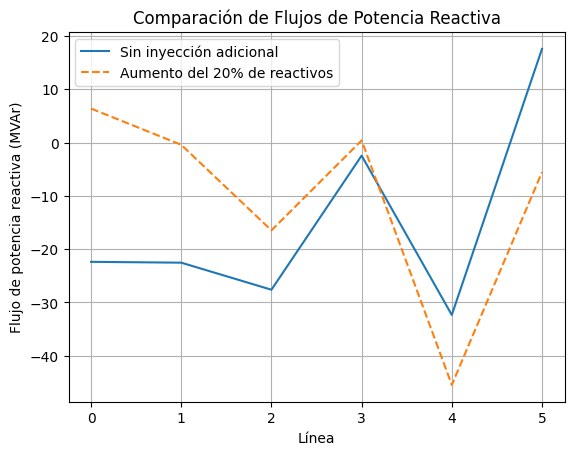

In [4]:
import pandapower as pp
import matplotlib.pyplot as plt

def create_network():
    net = pp.create_empty_network()
    # Carga Nominal Por Barra
    P2 = 150  # MW
    Q2 = 100  # MVAr

    # Barras
    b1 = pp.create_bus(net, vn_kv=110, name='Barra 1', slack=True)
    b2 = pp.create_bus(net, vn_kv=220, name="Barra 2")
    b1A = pp.create_bus(net, vn_kv=220, name="Barra 1A")
    b2A = pp.create_bus(net, vn_kv=220, name="Barra 2A")
    b3A = pp.create_bus(net, vn_kv=220, name="Barra 3A")
    b2B = pp.create_bus(net, vn_kv=220, name="Barra 2B")
    b1B = pp.create_bus(net, vn_kv=220, name="Barra 1B")

    # Elementos De Barra
    pp.create_ext_grid(net, bus=b1, vm_pu=1.00, name="Fuente Externa")
    pp.create_load(net, bus=b1A, p_mw=P2*0.2, q_mvar=Q2*0.2, name="Carga 1A")
    pp.create_load(net, bus=b2A, p_mw=P2*0.35, q_mvar=Q2*0.35, name="Carga 2A")
    pp.create_load(net, bus=b3A, p_mw=P2*0.15, q_mvar=Q2*0.15, name="Carga 3A")
    pp.create_load(net, bus=b2B, p_mw=P2*0.6, q_mvar=Q2*0.6, name="Carga 2B")
    pp.create_load(net, bus=b1B, p_mw=P2*0.1, q_mvar=Q2*0.1, name="Carga 1B")

    # Elementos De Rama
    tid = pp.create_transformer(net, hv_bus=b2, lv_bus=b1, std_type="100 MVA 220/110 kV", name="Trafo 1")

    # Líneas
    pp.create_line(net, from_bus=b2, to_bus=b1A, length_km=10, name="Linea 2-1A",
                   std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
    pp.create_line(net, from_bus=b1A, to_bus=b2A, length_km=15, name="Linea 1A-2A",
                   std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
    pp.create_line(net, from_bus=b2A, to_bus=b3A, length_km=20, name="Linea 2A-3A",
                   std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
    pp.create_line(net, from_bus=b3A, to_bus=b2B, length_km=15, name="Linea 3A-2B",
                   std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
    pp.create_line(net, from_bus=b2B, to_bus=b1B, length_km=30, name="Linea 2B-1B",
                   std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
    pp.create_line(net, from_bus=b1B, to_bus=b2, length_km=10, name="Linea 1B-2",
                   std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 

    return net

# Crear y correr la red sin la inyección adicional de potencia reactiva
net_without_reactive_injection = create_network()
pp.runpp(net_without_reactive_injection)

# Crear y correr la red con cargas incrementadas en un 20% para simular la inyección adicional de potencia reactiva
net_with_increased_loads = create_network()

# Incrementar la carga reactiva en un 20%
for load in net_with_increased_loads.load.index:
    net_with_increased_loads.load.at[load, 'q_mvar'] *= 1.2

pp.runpp(net_with_increased_loads)

# Comparar tensiones en las barras
#print("Tensiones sin inyección adicional de potencia reactiva:")
#print(net_without_reactive_injection.res_bus[['vm_pu']])

#print("Tensiones con cargas incrementadas:")
#print(net_with_increased_loads.res_bus[['vm_pu']])

# Comparar flujos de potencia en las líneas
#print("Flujos de potencia en las líneas sin inyección adicional de potencia reactiva:")
#print(net_without_reactive_injection.res_line[['p_from_mw', 'q_from_mvar', 'p_to_mw', 'q_to_mvar']])

#print("Flujos de potencia en las líneas con cargas incrementadas:")
#print(net_with_increased_loads.res_line[['p_from_mw', 'q_from_mvar', 'p_to_mw', 'q_to_mvar']])

# Generar figuras para comparar los resultados
# Tensiones
fig, ax = plt.subplots()
ax.plot(net_without_reactive_injection.res_bus.index, net_without_reactive_injection.res_bus.vm_pu, label="Sin inyección adicional")
ax.plot(net_with_increased_loads.res_bus.index, net_with_increased_loads.res_bus.vm_pu, label="Aumento del 20% de reactivos", linestyle='--')
ax.set_xlabel("Barra")
ax.set_ylabel("Tensión (pu)")
ax.set_title("Comparación de Tensiones")
ax.legend()
plt.grid(True)
plt.show()

# Flujos de potencia reactiva en las líneas
fig, ax = plt.subplots()
ax.plot(net_without_reactive_injection.res_line.index, net_without_reactive_injection.res_line.q_from_mvar, label="Sin inyección adicional")
ax.plot(net_with_increased_loads.res_line.index, net_with_increased_loads.res_line.q_from_mvar, label="Aumento del 20% de reactivos", linestyle='--')
ax.set_xlabel("Línea")
ax.set_ylabel("Flujo de potencia reactiva (MVAr)")
ax.set_title("Comparación de Flujos de Potencia Reactiva")
ax.legend()
plt.grid(True)
plt.show()


<div style="text-align: justify;">
Al inyectar reactivos extras, es normal ver cambios en cómo se distribuye la potencia reactiva en diferentes partes del sistema eléctrico. Algunas áreas pueden experimentar menos potencia reactiva debido a limitaciones en su capacidad para absorber más, mientras que otras podrían necesitar más reactivos para mantener la estabilidad de tensión. Este proceso destaca la importancia de planificar cuidadosamente cómo se manejan los reactivos para evitar impactos negativos, como las caídas de tensión que pueden afectar la operación de equipos sensibles. Asegurar una distribución equilibrada y efectiva de reactivos no solo mejora el factor de potencia, sino que también fortalece la capacidad del sistema para adaptarse a cambios en la demanda y en la red eléctrica, promoviendo así una operación segura y eficiente a largo plazo.

### E. Desconección de línea 3A-2B

In [1]:
import pandapower as pp

net4 = pp.create_empty_network()
#Carga Nominal Por Barra
P2 = 150 #MW
Q2 = 100 #MVAr
#Barras
b1 = pp.create_bus(net4, vn_kv=110, name='Barra 1', slack=True)
b2 = pp.create_bus(net4, vn_kv=220, name="Barra 2")
b1A = pp.create_bus(net4, vn_kv=220, name="Barra 1A")
b2A = pp.create_bus(net4, vn_kv=220, name="Barra 2A")
b3A = pp.create_bus(net4, vn_kv=220, name="Barra 3A")
b2B = pp.create_bus(net4, vn_kv=220, name="Barra 2B")
b1B = pp.create_bus(net4, vn_kv=220, name="Barra 1B")
#Elementos De Barra
pp.create_ext_grid(net4, bus=b1, vm_pu=1.00, name="Fuente Externa")
pp.create_load(net4, bus=b1A, p_mw=P2*0.2, q_mvar=Q2*0.2, name="Carga 1A")
pp.create_load(net4, bus=b2A, p_mw=P2*0.35, q_mvar=Q2*0.35, name="Carga 2A")
pp.create_load(net4, bus=b3A, p_mw=P2*0.15, q_mvar=Q2*0.15, name="Carga 3A")
pp.create_load(net4, bus=b2B, p_mw=P2*0.6, q_mvar=Q2*0.6, name="Carga 2B")
pp.create_load(net4, bus=b1B, p_mw=P2*0.1, q_mvar=Q2*0.1, name="Carga 1B")
#Elementos De Rama
tid = pp.create_transformer(net4, hv_bus=b2, lv_bus=b1, std_type="100 MVA 220/110 kV", name="Trafo 1")
#L 2 - 1A
pp.create_line(net4, from_bus=b2, to_bus=b1A, length_km=10, name="Linea 2-1A",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#L 1A - 2A
pp.create_line(net4, from_bus=b1A, to_bus=b2A, length_km=15, name="Linea 1A-2A",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#L 2A - 3A
pp.create_line(net4, from_bus=b2A, to_bus=b3A, length_km=20, name="Linea 2A-3A",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#L 3A - 2B (Desconectada)
pp.create_line(net4, from_bus=b3A, to_bus=b2B, length_km=15, name="Linea 3A-2B",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=False) 
#L 2B - 1B
pp.create_line(net4, from_bus=b2B, to_bus=b1B, length_km=30, name="Linea 2B-1B",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#L 1B - 2
pp.create_line(net4, from_bus=b1B, to_bus=b2, length_km=10, name="Linea 1B-2",
               std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
#Flujo De Carga
pp.runpp(net4)

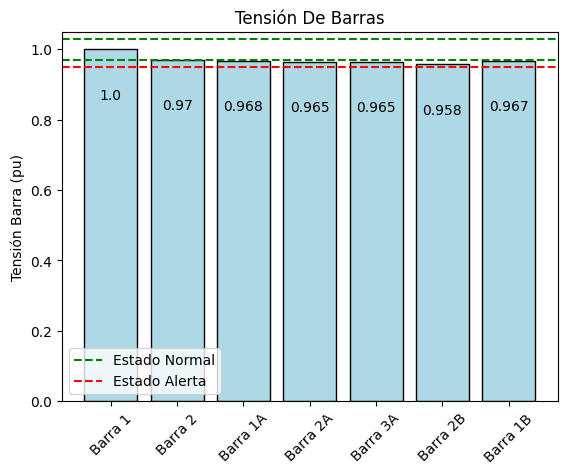

In [2]:
#B) Análisis de Tensiones de Barra
resultados_bus = net4.res_bus
import matplotlib.pyplot as plt
Bus = []
Voltage_pu = []
for n, lin in net4.bus.iterrows():
    Bus.append(lin['name'])
    res_bus1 = resultados_bus.loc[resultados_bus.index == n]
    Voltage_pu.append(round(res_bus1['vm_pu'].values[0],3))

plt.bar(Bus, Voltage_pu, color='lightblue',edgecolor='black') 
plt.axhline(y=0.97, color='g', linestyle='--',label='Estado Normal')  # Línea en y=15
plt.axhline(y=1.03, color='g', linestyle='--')  # Línea en y=15
plt.axhline(y=0.95, color='r', linestyle='--',label='Estado Alerta')   # Línea en y=20
plt.axhline(y=1.05, color='r', linestyle='--')   # Línea en y=20
plt.ylabel('Tensión Barra (pu)')
plt.xticks(rotation=45) 
plt.title('Tensión De Barras')
for i, valor in enumerate(Voltage_pu):
    plt.annotate(str(valor), xy=(i, valor-0.15), ha='center', va='bottom')
plt.legend() 
plt.show()

### G. Escenario De Variación De Cargas
<div style="text-align: justify;">

Puesto que las cargas no siempre mantienen su valor nominal constante (depende mucho del tipo de carga y su uso), se analiza el caso en el que las cargas conectadas a las barras del **Sistema B** varían de forma independiente $\pm 15\%$ de la potencia consumida. De esta manera, puesto que existen cinco cargas, se analizan cinco escenarios posibles y los cambios que su variación provoca en las variables principales del sistema.

</div>

In [18]:
import pandapower as pp
import math as mt
import numpy as np
import pickle

date_voltage = {}  #Almacenador de tensiones en barra
date_s = []        #Almacenador de potencia actual dentro del bucle for
date_line = {}     #Almacenador de cargabilidad de líneas
Lineas_n = ['1A','2A','3A','2B','1B']
#Carga Nominal Por Barra
Pc = [0.2,0.35,0.15,0.6,0.1] #Porcentaje en Carga (varía)
P2 = 150 #MW
Q2 = 100 #MVAr
S2 = mt.sqrt(P2**2 + Q2**2)
FPc = round(P2/S2,2) #Supuesto: Asumiremos que dentro del 15% de variación, FP se mantiene constante (Para todas las cargas)
for index, z in enumerate(Pc):
    S_min = round(mt.sqrt((P2*z-P2*z*0.15)**2 + (Q2*z-Q2*z*0.15)**2),2)
    S_max = round(mt.sqrt((P2*z+P2*z*0.15)**2 + (Q2*z+Q2*z*0.15)**2),2)
    Paso2 = 0.1
    for k in np.arange(S_min,S_max+0.1,Paso2): 
        net3 = pp.create_empty_network()
        P_load = round(k*FPc, 2)
        Q_load = round(k*mt.sqrt(1 - FPc**2), 2)
        #Barras
        b1 = pp.create_bus(net3, vn_kv=110, name='Barra 1', slack=True)
        b2 = pp.create_bus(net3, vn_kv=220, name="Barra 2")
        b1A = pp.create_bus(net3, vn_kv=220, name="Barra 1A")
        b2A = pp.create_bus(net3, vn_kv=220, name="Barra 2A")
        b3A = pp.create_bus(net3, vn_kv=220, name="Barra 3A")
        b2B = pp.create_bus(net3, vn_kv=220, name="Barra 2B")
        b1B = pp.create_bus(net3, vn_kv=220, name="Barra 1B")
        #Elementos De Barra
        pp.create_ext_grid(net3, bus=b1, vm_pu=1.00, name="Fuente Externa")
        if index == 0:
            pp.create_load(net3, bus=b1A, p_mw=P_load, q_mvar=Q_load, name="Carga 1A")
        else:
            pp.create_load(net3, bus=b1A, p_mw=P2*0.2, q_mvar=Q2*0.2, name="Carga 1A")
        if index == 1:
            pp.create_load(net3, bus=b2A, p_mw=P_load, q_mvar=Q_load, name="Carga 2A")
        else:
            pp.create_load(net3, bus=b2A, p_mw=P2*0.35, q_mvar=Q2*0.35, name="Carga 2A")
        if index == 2:
            pp.create_load(net3, bus=b3A, p_mw=P_load, q_mvar=Q_load, name="Carga 3A")
        else:
            pp.create_load(net3, bus=b3A, p_mw=P2*0.15, q_mvar=Q2*0.15, name="Carga 3A")
        if index == 3:
            pp.create_load(net3, bus=b2B, p_mw=P_load, q_mvar=Q_load, name="Carga 2B")
        else:
            pp.create_load(net3, bus=b2B, p_mw=P2*0.6, q_mvar=Q2*0.6, name="Carga 2B")
        if index == 4:
             pp.create_load(net3, bus=b1B, p_mw=P_load, q_mvar=Q_load, name="Carga 1B")
        else:
            pp.create_load(net3, bus=b1B, p_mw=P2*0.1, q_mvar=Q2*0.1, name="Carga 1B")
        #Elementos De Rama
        tid = pp.create_transformer(net3, hv_bus=b2, lv_bus=b1, std_type="100 MVA 220/110 kV", name="Trafo 1")
        pp.create_line(net3, from_bus=b2, to_bus=b1A, length_km=10, name="Linea 2-1A", std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
        pp.create_line(net3, from_bus=b1A, to_bus=b2A, length_km=15, name="Linea 1A-2A", std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
        pp.create_line(net3, from_bus=b2A, to_bus=b3A, length_km=20, name="Linea 2A-3A", std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
        pp.create_line(net3, from_bus=b3A, to_bus=b2B, length_km=15, name="Linea 3A-2B", std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
        pp.create_line(net3, from_bus=b2B, to_bus=b1B, length_km=30, name="Linea 2B-1B", std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
        pp.create_line(net3, from_bus=b1B, to_bus=b2, length_km=10, name="Linea 1B-2", std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True) 
        #Flujo De Carga
        pp.runpp(net3)
        date_s.append("{:.1f}".format(k))
        v_name = []
        v_value = []
        l_name = []
        l_value = []
        for bus_index, bus_row in net3.bus.iterrows():
            v_name.append(bus_row['name'])
            res_bus = net3.res_bus.loc[net3.res_bus.index == bus_index]
            v_value.append(round(res_bus['vm_pu'].values[0], 3))  # Aquí se obtiene vm_pu correctamente
        date_voltage[str("{:.1f}".format(k))] = (v_name, v_value)  # Guardar resultados para esta iteración
        for line_index, line_row in net3.line.iterrows():
            l_name.append(line_row['name'])
            res_line = net3.res_line.loc[net3.res_line.index == line_index]
            l_value.append(round(res_line['loading_percent'].values[0], 1))
        date_line[str("{:.1f}".format(k))] = (l_name, l_value)
        #for z, x in net3.bus.iterrows():
        #    v_name.append(x['name'])
        #    res_bus0 = net3.res_bus.loc[net3.res_bus.index == z]
        #    v_value.append(round(res_bus0['vm_pu'].values[0],3))
        #date_voltage[str("{:.1f}".format(k))] = (v_name,v_value)
        #for h, f in net3.line.iterrows():
        #    l_name.append(f['name'])
        #    res_line0 = net3.res_line.loc[net3.res_line.index == h]
        #    l_value.append(round(res_line0['loading_percent'].values[0],1))
        #date_voltage[str("{:.1f}".format(k))] = (v_name,v_value)
        #date_line[str("{:.1f}".format(k))] = (l_name,l_value)
    date_s = [float(numero) for numero in date_s]
    #GUARDADO DE SIMULACIONES POR VARIABLE
    name = Lineas_n[index]
    base_filename1 = f"SIMULACIONES/carga_{name}_potS.pkl"
    base_filename2 = f"SIMULACIONES/carga_{name}_bus.pkl"
    base_filename3 = f"SIMULACIONES/carga_{name}_line.pkl"
    with open(base_filename1, 'wb') as f:
        pickle.dump(date_s, f)
    with open(base_filename2, 'wb') as f:
        pickle.dump(date_voltage, f)
    with open(base_filename3, 'wb') as f:
        pickle.dump(date_line, f)


**1. Carga de la Barra 1A**

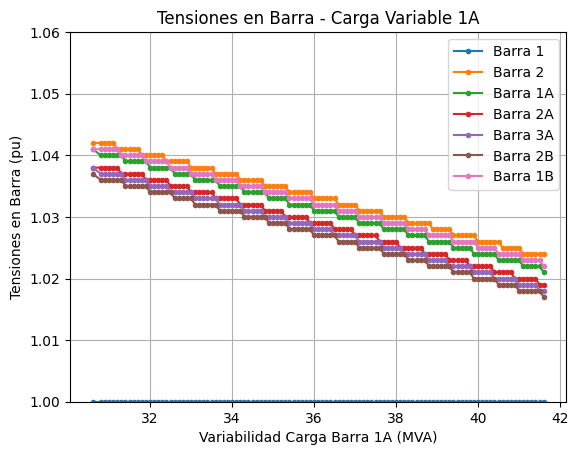

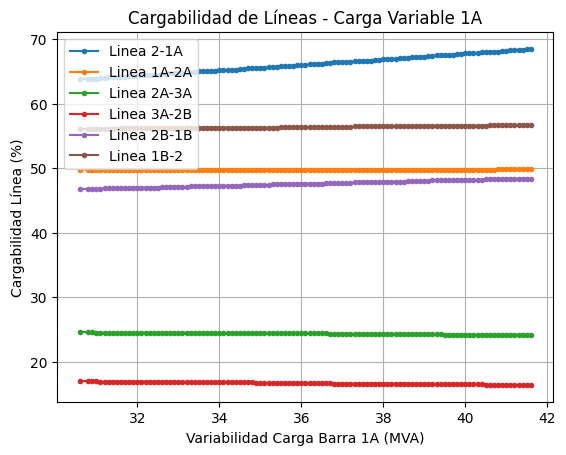

In [21]:
import pickle
import matplotlib.pyplot as plt
#Se cargan archivos Simulados
with open('SIMULACIONES/carga_1A_potS.pkl', 'rb') as f:
    S_1A = pickle.load(f)
with open('SIMULACIONES/carga_1A_bus.pkl', 'rb') as f:
    BUS_1A = pickle.load(f)
with open('SIMULACIONES/carga_1A_line.pkl', 'rb') as f:
    LINE_1A = pickle.load(f)
#GRAFICO DE TENSIONES EN BARRA
Bus_p1A = []
Voltage_p1A = []
contx = 1
for llave1 in BUS_1A.keys():
    a,b = BUS_1A[llave1]
    if contx == 1:
        Bus_p1A = a
    Voltage_p1A.append(b)
    contx = contx + 1
for u in Bus_p1A:
    voltage_temp = []
    num_bar = Bus_p1A.index(u)
    for b in Voltage_p1A:
        voltage_temp.append(b[num_bar])
    plt.plot(S_1A, voltage_temp, marker='.', linestyle='-', label=u)
plt.title('Tensiones en Barra - Carga Variable 1A')
plt.xlabel('Variabilidad Carga Barra 1A (MVA)')
plt.ylabel('Tensiones en Barra (pu)')
plt.ylim(1, 1.06)
plt.grid(True)
plt.legend() 
plt.show()
#GRAFICO DE CARGABILIDAD DE LÍNEA
Line_p1A = []
Carg_p1A = []
contx = 1
for llave2 in LINE_1A.keys():
    a,b = LINE_1A[llave2]
    if contx == 1:
        Line_p1A = a
    Carg_p1A.append(b)
    contx = contx + 1
for u in Line_p1A:
    carga_temp = []
    num_line = Line_p1A.index(u)
    for b in Carg_p1A:
        carga_temp.append(b[num_line])
    plt.plot(S_1A, carga_temp, marker='.', linestyle='-', label=u)
plt.title('Cargabilidad de Líneas - Carga Variable 1A')
plt.xlabel('Variabilidad Carga Barra 1A (MVA)')
plt.ylabel('Cargabilidad Línea (%)')
#plt.ylim(1, 1.06)
plt.grid(True)
plt.legend() 
plt.show()

**2. Carga de la Barra 2A**

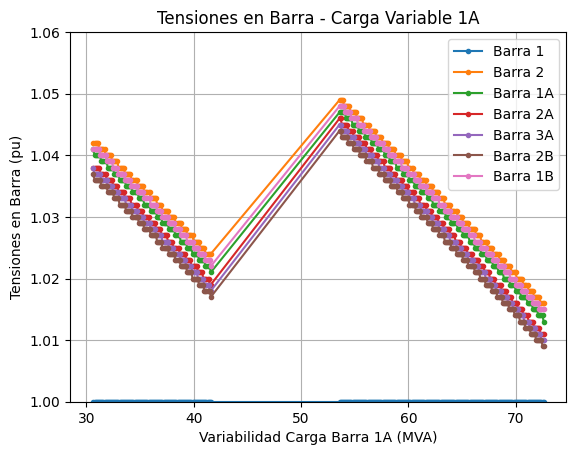

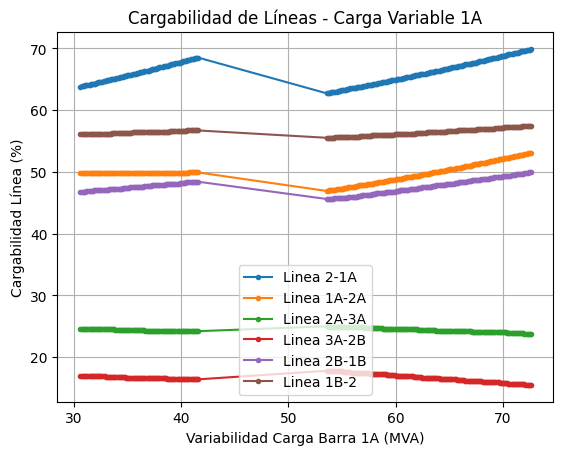

In [25]:
import pickle
import matplotlib.pyplot as plt
#Se cargan archivos Simulados
with open('SIMULACIONES/carga_2A_potS.pkl', 'rb') as f:
    S_1A = pickle.load(f)
with open('SIMULACIONES/carga_2A_bus.pkl', 'rb') as f:
    BUS_1A = pickle.load(f)
with open('SIMULACIONES/carga_2A_line.pkl', 'rb') as f:
    LINE_1A = pickle.load(f)
#GRAFICO DE TENSIONES EN BARRA
Bus_p1A = []
Voltage_p1A = []
contx = 1
for llave1 in BUS_1A.keys():
    a,b = BUS_1A[llave1]
    if contx == 1:
        Bus_p1A = a
    Voltage_p1A.append(b)
    contx = contx + 1
for u in Bus_p1A:
    voltage_temp = []
    num_bar = Bus_p1A.index(u)
    for b in Voltage_p1A:
        voltage_temp.append(b[num_bar])
    plt.plot(S_1A, voltage_temp, marker='.', linestyle='-', label=u)
plt.title('Tensiones en Barra - Carga Variable 1A')
plt.xlabel('Variabilidad Carga Barra 1A (MVA)')
plt.ylabel('Tensiones en Barra (pu)')
plt.ylim(1, 1.06)
plt.grid(True)
plt.legend() 
plt.show()
#GRAFICO DE CARGABILIDAD DE LÍNEA
Line_p1A = []
Carg_p1A = []
contx = 1
for llave2 in LINE_1A.keys():
    a,b = LINE_1A[llave2]
    if contx == 1:
        Line_p1A = a
    Carg_p1A.append(b)
    contx = contx + 1
for u in Line_p1A:
    carga_temp = []
    num_line = Line_p1A.index(u)
    for b in Carg_p1A:
        carga_temp.append(b[num_line])
    plt.plot(S_1A, carga_temp, marker='.', linestyle='-', label=u)
plt.title('Cargabilidad de Líneas - Carga Variable 1A')
plt.xlabel('Variabilidad Carga Barra 1A (MVA)')
plt.ylabel('Cargabilidad Línea (%)')
#plt.ylim(1, 1.06)
plt.grid(True)
plt.legend() 
plt.show()

**3. Carga de la Barra 3A**

ValueError: x and y must have same first dimension, but have shapes (384,) and (378,)

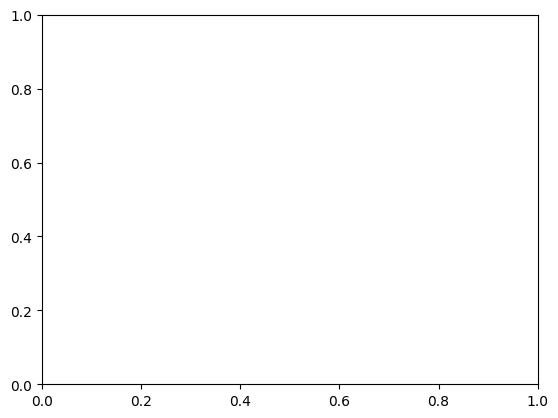

In [24]:
import pickle
import matplotlib.pyplot as plt
#Se cargan archivos Simulados
with open('SIMULACIONES/carga_3A_potS.pkl', 'rb') as f:
    S_1A = pickle.load(f)
with open('SIMULACIONES/carga_3A_bus.pkl', 'rb') as f:
    BUS_1A = pickle.load(f)
with open('SIMULACIONES/carga_3A_line.pkl', 'rb') as f:
    LINE_1A = pickle.load(f)
#GRAFICO DE TENSIONES EN BARRA
Bus_p1A = []
Voltage_p1A = []
contx = 1
for llave1 in BUS_1A.keys():
    a,b = BUS_1A[llave1]
    if contx == 1:
        Bus_p1A = a
    Voltage_p1A.append(b)
    contx = contx + 1
for u in Bus_p1A:
    voltage_temp = []
    num_bar = Bus_p1A.index(u)
    for b in Voltage_p1A:
        voltage_temp.append(b[num_bar])
    plt.plot(S_1A, voltage_temp, marker='.', linestyle='-', label=u)
plt.title('Tensiones en Barra - Carga Variable 1A')
plt.xlabel('Variabilidad Carga Barra 1A (MVA)')
plt.ylabel('Tensiones en Barra (pu)')
plt.ylim(1, 1.06)
plt.grid(True)
plt.legend() 
plt.show()
#GRAFICO DE CARGABILIDAD DE LÍNEA
Line_p1A = []
Carg_p1A = []
contx = 1
for llave2 in LINE_1A.keys():
    a,b = LINE_1A[llave2]
    if contx == 1:
        Line_p1A = a
    Carg_p1A.append(b)
    contx = contx + 1
for u in Line_p1A:
    carga_temp = []
    num_line = Line_p1A.index(u)
    for b in Carg_p1A:
        carga_temp.append(b[num_line])
    plt.plot(S_1A, carga_temp, marker='.', linestyle='-', label=u)
plt.title('Cargabilidad de Líneas - Carga Variable 1A')
plt.xlabel('Variabilidad Carga Barra 1A (MVA)')
plt.ylabel('Cargabilidad Línea (%)')
#plt.ylim(1, 1.06)
plt.grid(True)
plt.legend() 
plt.show()

**4. Carga de la Barra 2B**

ValueError: x and y must have same first dimension, but have shapes (710,) and (704,)

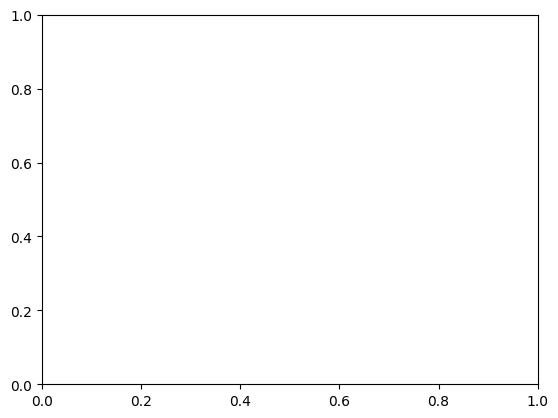

In [23]:
import pickle
import matplotlib.pyplot as plt
#Se cargan archivos Simulados
with open('SIMULACIONES/carga_2B_potS.pkl', 'rb') as f:
    S_1A = pickle.load(f)
with open('SIMULACIONES/carga_2B_bus.pkl', 'rb') as f:
    BUS_1A = pickle.load(f)
with open('SIMULACIONES/carga_2B_line.pkl', 'rb') as f:
    LINE_1A = pickle.load(f)
#GRAFICO DE TENSIONES EN BARRA
Bus_p1A = []
Voltage_p1A = []
contx = 1
for llave1 in BUS_1A.keys():
    a,b = BUS_1A[llave1]
    if contx == 1:
        Bus_p1A = a
    Voltage_p1A.append(b)
    contx = contx + 1
for u in Bus_p1A:
    voltage_temp = []
    num_bar = Bus_p1A.index(u)
    for b in Voltage_p1A:
        voltage_temp.append(b[num_bar])
    plt.plot(S_1A, voltage_temp, marker='.', linestyle='-', label=u)
plt.title('Tensiones en Barra - Carga Variable 1A')
plt.xlabel('Variabilidad Carga Barra 1A (MVA)')
plt.ylabel('Tensiones en Barra (pu)')
plt.ylim(1, 1.06)
plt.grid(True)
plt.legend() 
plt.show()
#GRAFICO DE CARGABILIDAD DE LÍNEA
Line_p1A = []
Carg_p1A = []
contx = 1
for llave2 in LINE_1A.keys():
    a,b = LINE_1A[llave2]
    if contx == 1:
        Line_p1A = a
    Carg_p1A.append(b)
    contx = contx + 1
for u in Line_p1A:
    carga_temp = []
    num_line = Line_p1A.index(u)
    for b in Carg_p1A:
        carga_temp.append(b[num_line])
    plt.plot(S_1A, carga_temp, marker='.', linestyle='-', label=u)
plt.title('Cargabilidad de Líneas - Carga Variable 1A')
plt.xlabel('Variabilidad Carga Barra 1A (MVA)')
plt.ylabel('Cargabilidad Línea (%)')
#plt.ylim(1, 1.06)
plt.grid(True)
plt.legend() 
plt.show()

**5. Carga de la Barra 1B**

ValueError: x and y must have same first dimension, but have shapes (766,) and (760,)

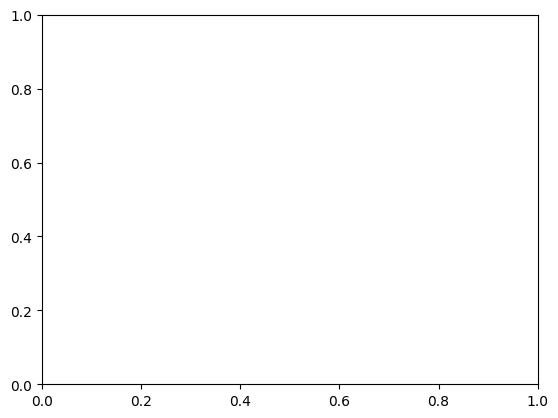

In [22]:
import pickle
import matplotlib.pyplot as plt
#Se cargan archivos Simulados
with open('SIMULACIONES/carga_1B_potS.pkl', 'rb') as f:
    S_1A = pickle.load(f)
with open('SIMULACIONES/carga_1B_bus.pkl', 'rb') as f:
    BUS_1A = pickle.load(f)
with open('SIMULACIONES/carga_1B_line.pkl', 'rb') as f:
    LINE_1A = pickle.load(f)
#GRAFICO DE TENSIONES EN BARRA
Bus_p1A = []
Voltage_p1A = []
contx = 1
for llave1 in BUS_1A.keys():
    a,b = BUS_1A[llave1]
    if contx == 1:
        Bus_p1A = a
    Voltage_p1A.append(b)
    contx = contx + 1
for u in Bus_p1A:
    voltage_temp = []
    num_bar = Bus_p1A.index(u)
    for b in Voltage_p1A:
        voltage_temp.append(b[num_bar])
    plt.plot(S_1A, voltage_temp, marker='.', linestyle='-', label=u)
plt.title('Tensiones en Barra - Carga Variable 1A')
plt.xlabel('Variabilidad Carga Barra 1A (MVA)')
plt.ylabel('Tensiones en Barra (pu)')
plt.ylim(1, 1.06)
plt.grid(True)
plt.legend() 
plt.show()
#GRAFICO DE CARGABILIDAD DE LÍNEA
Line_p1A = []
Carg_p1A = []
contx = 1
for llave2 in LINE_1A.keys():
    a,b = LINE_1A[llave2]
    if contx == 1:
        Line_p1A = a
    Carg_p1A.append(b)
    contx = contx + 1
for u in Line_p1A:
    carga_temp = []
    num_line = Line_p1A.index(u)
    for b in Carg_p1A:
        carga_temp.append(b[num_line])
    plt.plot(S_1A, carga_temp, marker='.', linestyle='-', label=u)
plt.title('Cargabilidad de Líneas - Carga Variable 1A')
plt.xlabel('Variabilidad Carga Barra 1A (MVA)')
plt.ylabel('Cargabilidad Línea (%)')
#plt.ylim(1, 1.06)
plt.grid(True)
plt.legend() 
plt.show()

## Referencias

[1] Norma Técnica De Calidad y Seguridad de Servicio. Extraída desde página web: https://www.cne.cl/normativas/electrica/normas-tecnicas/ 
